<a href="https://colab.research.google.com/github/chunsengwong/the-speech-emotion-recognition/blob/main/SER_PDSSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import pandas as pd
from google.colab import files
from matplotlib.pyplot import fill
import pickle
import librosa
from librosa import feature
import soundfile
import numpy as np
!pip install pickle
!pip install pydub
import os
#install google cloud speech
!pip install --upgrade google-cloud-speech
from google.cloud import speech

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.7/273.7 kB 5.0 MB/s eta 0:00:00


In [2]:
#set google environment & credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= '/content/focus-cache-352904-21b9fded3bd2.json'
speech_client=speech.SpeechClient()
from pydub import AudioSegment
from pydub.playback import play
from IPython.display import Audio, display


In [3]:
path="/content/sample.wav"# Load the audio file
audio = AudioSegment.from_wav(path)

# Set the desired sample rate (in Hz)
new_sample_rate = 16000

# Resample the audio to the desired sample rate
resampled_audio = audio.set_frame_rate(new_sample_rate)
# Convert the audio to the desired sample width
resampled_audio = audio.set_sample_width(2)
# Export the resampled audio to a new WAV file
resampled_audio.export('/content/output.wav', format='wav')
with open('/content/output.wav', "rb") as audio_file:
    wavfile = audio_file.read()
#import for audio functions
audioWav = speech.RecognitionAudio(content=wavfile)

#create class for audio
class Audioseg:
  def __init__(self, path, start, end):
    self.starttime=start*1000
    self.endtime = end*1000
    self.path=path

#configure wav file
configWav = speech.RecognitionConfig(
       encoding = 'LINEAR16',
        language_code = 'en_us',
        sample_rate_hertz = 48000,
        #audio_channel_count = 2,
        enable_automatic_punctuation=True,
        enable_word_time_offsets=True
)

def extractFeature (fileName, mfcc, chroma, mel ):
    with soundfile.SoundFile(fileName) as soundFile:
        X=soundFile.read(dtype="float32")
        sampleRate=soundFile.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sampleRate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))

        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sampleRate).T, axis=0)
            result=np.hstack((result, chroma))

        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sampleRate).T,axis=0)
            result=np.hstack((result,mel))


    return result

import joblib
loaded_model = pickle.load(open("SER.sav", 'rb'))
def MLPfunction(feature):
    #loaded_model = pickle.load(open("SER.sav", 'rb'))
    y_pre=loaded_model.predict([feature])
    #print(y_pre)
    return y_pre



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
#transcript and automatic punctuation added

response = speech_client.long_running_recognize(config=configWav, audio=audioWav)
done=0
#a list to store audio fragments
audioList=[]
AudioS=[]
sentences=[]
sentencesWords=""
print("Original audio: ")
display(AudioSegment.from_wav(path))

print("Waiting for operation to complete...\n\n-------------------------------------")
print("Transcript: \n")
response = response.result(timeout=90)

for result in response.results:


    print("{}".format(result.alternatives[0].transcript))

print("\n observed emotion: ['sad', 'fearful', 'disgust', 'happy', 'angry']\n")
print("indicators: '.' , '!' , '?'")
for i, result in enumerate(response.results):
    alternative = result.alternatives[0]
    for word_info in alternative.words:
            word = word_info.word
            start_time = word_info.start_time
            end_time = word_info.end_time
            sentencesWords=sentencesWords+" "+word

            if(done==0):
                start=start_time.total_seconds()
                done=1


            if word[-1]=='.' or word[-1]=='!' or word[-1]=='?' :
                  done=0
                  sentences.append(sentencesWords)
                  sentencesWords=""
                  AudioS.append(Audioseg(path, start, end_time.total_seconds()))
                  newAudio = AudioSegment.from_wav(AudioS[len(AudioS)-1].path)
                  newAudio = newAudio[AudioS[len(AudioS)-1].starttime:AudioS[len(AudioS)-1].endtime]
                  audioList.append(newAudio)

print(f"\n\n\nAudio fragments (total {(len(audioList))}):")
j=0
emotionData=[]
for i in audioList:
  print("Sentence " , (j+1) , ":", sentences[j])
  #print(len(sentences))
  display(i)
  i.export("temp.wav", format="wav")
  print("path: " , AudioS[j].path , "\n", (AudioS[j].starttime/1000) , ": ", (AudioS[j].endtime/1000), " (second)")
  j=j+1
  feature=extractFeature("temp.wav", mfcc=True, chroma=True, mel=True)

  print("Result: ", MLPfunction(feature))

  emotionData.append(MLPfunction(feature))
  print("\n")


Original audio: 


Waiting for operation to complete...

-------------------------------------
Transcript: 

Open your book to the first page.
 Fish is 8, the Nets and swim off.
 The pale once and let it settle.
 Will you please answer the phone?
 The big red, apple fell to the ground.

 observed emotion: ['sad', 'fearful', 'disgust', 'happy', 'angry']




Audio fragments (total 5):
Sentence  1 :  Open your book to the first page.


path:  /content/sample.wav 
 0.0 :  2.0  (second)
Result:  ['fearful']


Sentence  2 :  Fish is 8, the Nets and swim off.


path:  /content/sample.wav 
 5.9 :  8.0  (second)
Result:  ['fearful']


Sentence  3 :  The pale once and let it settle.


path:  /content/sample.wav 
 11.5 :  14.0  (second)
Result:  ['fearful']


Sentence  4 :  Will you please answer the phone?


path:  /content/sample.wav 
 17.3 :  18.8  (second)
Result:  ['sad']


Sentence  5 :  The big red, apple fell to the ground.


path:  /content/sample.wav 
 22.2 :  24.2  (second)
Result:  ['sad']




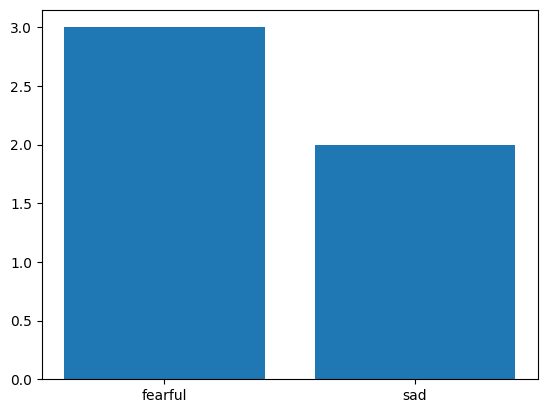

In [6]:
#plot bars
from matplotlib import pyplot as plt
keys, counts = np.unique(emotionData, return_counts=True)
plt.bar(keys, counts)
plt.show()